In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
!tar xf /content/drive/MyDrive/Big_Data/spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

tar: /content/drive/MyDrive/Big_Data/spark-3.1.1-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [42]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [43]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [44]:
import findspark
findspark.init()

In [45]:
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier, LinearSVC, OneVsRest
from pyspark.sql.types import LongType, StringType, DoubleType, IntegerType, ArrayType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import SparkSession, Window
from pyspark import SparkContext,SparkConf
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession,Row
from pyspark.ml.clustering import KMeans
from pyspark.sql.window import Window
from pyspark.ml.fpm import FPGrowth
from itertools import combinations
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from functools import reduce
import pandas as pd
import numpy as np
import findspark
import os

In [46]:
path = "/content/drive/MyDrive/Big_Data/datasets/"

# Câu 1: Phân cụm dữ liệu

+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

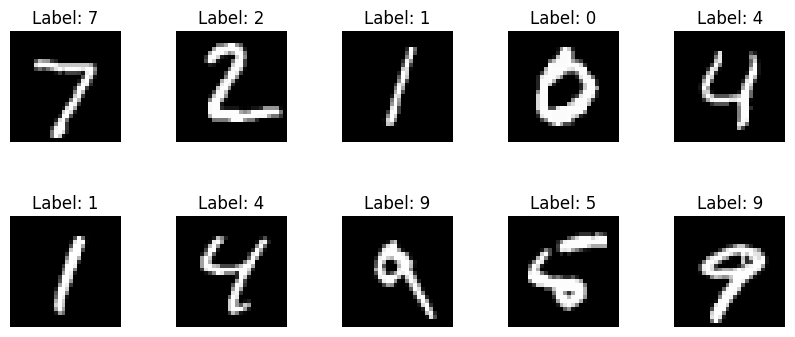

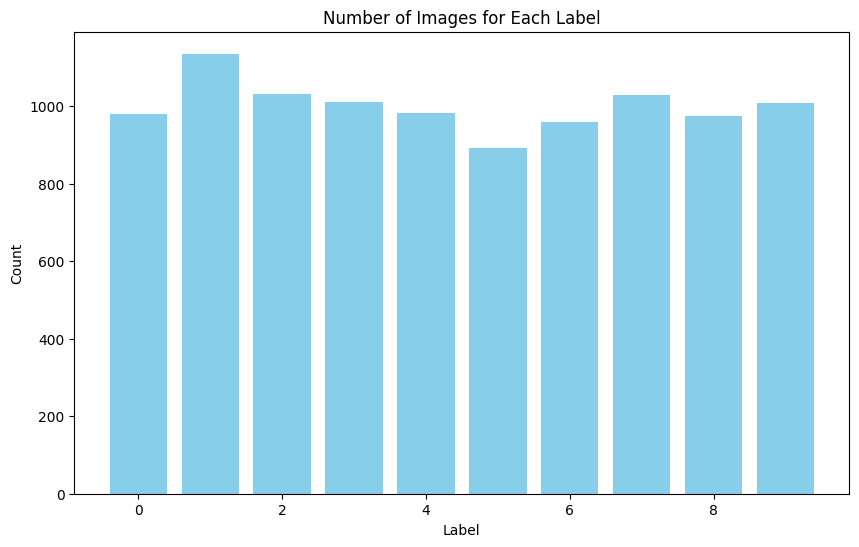

In [47]:
# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("Final") \
    .getOrCreate()

# Đọc dữ liệu từ file CSV vào DataFrame
data_path_mnist_mini= "/content/drive/MyDrive/Big_Data/datasets/mnist_mini.csv"
df = spark.read.csv(data_path_mnist_mini, header=False, inferSchema=True)

# Xem một số dòng đầu tiên của DataFrame
df.show(3)
print("Number of rows:", df.count())

# Chọn một số dòng dữ liệu để hiển thị
sample_data = df.take(10)

# Hiển thị một số ảnh từ dữ liệu mẫu
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(10):
    img = np.array(sample_data[i][1:]).reshape(28, 28)
    axs[i//5, i%5].imshow(img, cmap='gray')
    axs[i//5, i%5].set_title(f"Label: {sample_data[i][0]}")
    axs[i//5, i%5].axis('off')
plt.show()

# Thống kê số lượng các nhãn
label_counts = df.groupBy("_c0").count().orderBy("_c0").collect()

# Trích xuất nhãn và số lượng từ kết quả
labels = [row["_c0"] for row in label_counts]
counts = [row["count"] for row in label_counts]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Number of Images for Each Label')
plt.show()

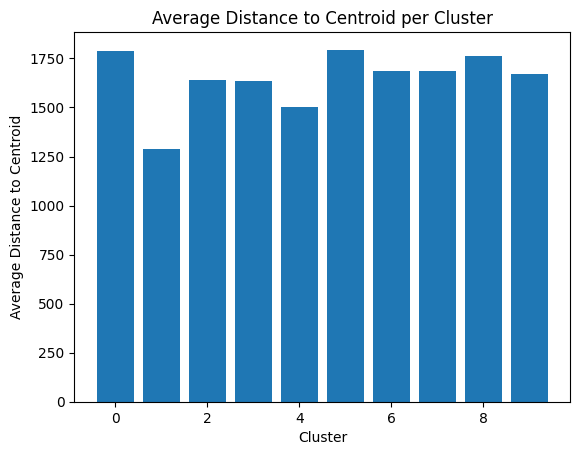

In [48]:
class MNISTClustering:
    def __init__(self,spark,  data_path, weighted_indices, k=10):
        """
        Initializes the MNISTClustering class.
        Parameters:
        - data_path: str, path to the MNIST dataset.
        - weighted_indices: list of int, indices of rows to be weighted more heavily.
        - k: int, number of clusters for KMeans.
        """
        self.spark = spark
        self.df = self.spark.read.csv(data_path, header=False, inferSchema=True)
        self.weighted_indices = weighted_indices
        self.k = k
        self.predictions = None

    def preprocess(self):
        """
        Preprocesses the data by assembling features and applying weights to specified indices.
        """
        assembler = VectorAssembler(inputCols=self.df.columns[1:], outputCol="features")
        self.df = assembler.transform(self.df)
        self.df = self.df.withColumn("weight", F.lit(1))
        self.df = self.df.withColumn("index", F.monotonically_increasing_id())
        windowSpec = Window.orderBy("index")
        self.df = self.df.withColumn("index", F.row_number().over(windowSpec) - 1)
        self.df = self.df.withColumn(
            "weight",
            F.when(F.col("index").isin(self.weighted_indices), F.col("weight") * 100).otherwise(F.col("weight"))
        )

    def cluster(self):
        """
        Performs KMeans clustering on the preprocessed data.
        """
        kmeans = KMeans(k=self.k, seed=42, featuresCol="features", weightCol="weight")
        self.model = kmeans.fit(self.df)
        self.predictions = self.model.transform(self.df)

    def analyze(self):
        """
        Analyzes the clustering results by computing the average distance of points to their cluster centroids.
        Returns:
        - avg_distances: list of float, average distances to the centroids for each cluster.
        """
        centroids = self.model.clusterCenters()
        def compute_distance(features, centroid):
            return float(np.linalg.norm(features - centroid))
        distances = self.predictions.rdd.map(
            lambda row: (row['prediction'], (compute_distance(row['features'], centroids[row['prediction']]), 1))
        ).reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])).mapValues(
            lambda x: x[0] / x[1]
        ).collect()
        avg_distances = [0] * self.k
        for cluster, avg_distance in distances:
            avg_distances[cluster] = avg_distance
        return avg_distances

    def visualize(self, avg_distances):
        """
        Visualizes the average distance to centroid per cluster using a bar chart.
        Parameters:
        - avg_distances: list of float, average distances to the centroids for each cluster.
        """
        plt.bar(range(self.k), avg_distances)
        plt.xlabel('Cluster')
        plt.ylabel('Average Distance to Centroid')
        plt.title('Average Distance to Centroid per Cluster')
        plt.show()

    def run(self):
        """
        Runs the full clustering analysis: preprocessing, clustering, analysis, and visualization.
        """
        self.preprocess()
        self.cluster()
        avg_distances = self.analyze()
        self.visualize(avg_distances)

if __name__ == "__main__":
    data_path_mnist_mini = "/content/drive/MyDrive/Big_Data/datasets/mnist_mini.csv"
    weighted_indices = [0, 1, 2, 3, 4, 7, 8, 11, 18, 61]
    analysis = MNISTClustering(spark,data_path_mnist_mini, weighted_indices)
    analysis.run()

# Câu 2: Giảm số chiều với SVD

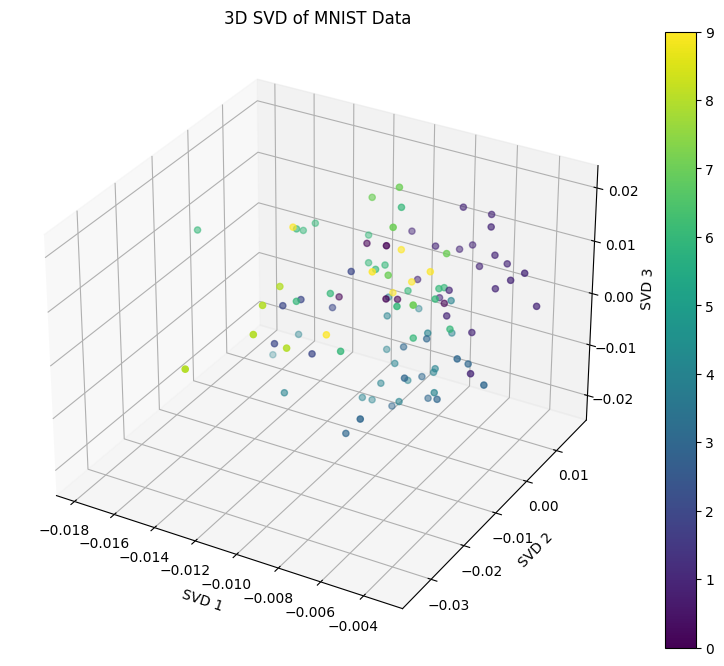

In [49]:
from pyspark.ml.linalg import Vectors as MLVectors
from pyspark.mllib.linalg import Vectors as MLLibVectors
from pyspark.mllib.linalg.distributed import RowMatrix
import numpy as np
import matplotlib.pyplot as plt

class MNISTSVD:
    def __init__(self, spark, predictions, k=3, n=100):
        """
        Initializes the MNISTSVD class.
        Parameters:
        - predictions: DataFrame, predictions from a clustering model.
        - k: int, number of principal components to retain.
        - n: int, number of data points to sample for visualization.
        """
        self.spark = spark
        self.predictions = predictions
        self.k = k
        self.n = n

    def reduce_dimensions(self):
        """
        Reduces the dimensions of the input data using SVD.
        Returns:
        - svd_result: DataFrame, transformed data with reduced dimensions.
        """
        assembled_data = self.predictions.select("features", "prediction")
        prediction = self.predictions.select("prediction")
        rows = assembled_data.rdd.map(lambda row: (MLLibVectors.dense(row["features"].toArray()), row["prediction"]))
        mat = RowMatrix(rows.map(lambda row: row[0]))
        svd = mat.computeSVD(self.k, computeU=True)
        U = svd.U.rows.map(lambda row: row.tolist())
        svd_df = spark.createDataFrame(U,["col1", "col2", "col3"])
        svd_df = svd_df.withColumn("index", F.monotonically_increasing_id())
        prediction = prediction.withColumn("index", F.monotonically_increasing_id())
        svd_result = svd_df.join(prediction, on="index").drop("index")

        return svd_result

    def sample_data(self, svd_result):
        """
        Samples data for visualization.
        Parameters:
        - svd_result: DataFrame, data with reduced dimensions.
        Returns:
        - svd_features_np: numpy array, sampled SVD features.
        - sampled_predictions: numpy array, sampled predictions.
        """
        sampled_data = svd_result.sample(withReplacement=False, fraction=float(self.n) / svd_result.count(), seed=3).limit(100)
        sampled_data_pd = sampled_data.toPandas()
        svd_features_np = np.array(sampled_data_pd[["col1", "col2", "col3"]].values.tolist())
        sampled_predictions = np.array(sampled_data_pd["prediction"].tolist())

        return svd_features_np, sampled_predictions

    def plot_3d(self, svd_features_np, sampled_predictions):
        """
        Plots the sampled data in 3D.
        Parameters:
        - svd_features_np: numpy array, sampled SVD features.
        - sampled_predictions: numpy array, sampled predictions.
        """
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(svd_features_np[:, 0], svd_features_np[:, 1], svd_features_np[:, 2], c=sampled_predictions, cmap="viridis")
        plt.colorbar(sc)
        ax.set_xlabel("SVD 1")
        ax.set_ylabel("SVD 2")
        ax.set_zlabel("SVD 3")
        plt.title("3D SVD of MNIST Data")
        plt.show()

    def run(self):
        """
        Runs the entire SVD analysis.
        """
        svd_result = self.reduce_dimensions()
        svd_features_np, sampled_predictions = self.sample_data(svd_result)
        self.plot_3d(svd_features_np, sampled_predictions)

if __name__ == "__main__":
    predictions_df = analysis.predictions
    svd_analysis = MNISTSVD(spark, predictions_df)
    svd_analysis.run()


# Câu 3: Khuyến nghị sản phẩm với Collaborative Filtering

In [50]:
class CollaborativeFiltering:
    def __init__(self, filepath, rank_value=10, regParam_value=0.1, maxIter_value=10, list_num_users=list(range(10,21))):
        self.spark = SparkSession.builder.appName("CollaborativeFiltering").getOrCreate()
        self.data = self.spark.read.csv(filepath, header=True, inferSchema=True)
        (self.train, self.test) = self.data.randomSplit([0.7, 0.3], seed=96)
        self.rank_value = int(rank_value)
        self.regParam_value = float(regParam_value)
        self.maxIter_value = int(maxIter_value)
        self.list_num_users = list(map(lambda x: int(x), list_num_users))
        self.best_mse_test = float('inf')
        self.best_model = None
        self.best_params = None

    def train_model(self, rank, regParam, maxIter):
        als = ALS(rank=rank,
                  regParam=regParam,
                  maxIter=maxIter,
                  userCol="user",
                  itemCol="item",
                  ratingCol="rating")
        model = als.fit(self.train)
        return model

    def evaluate_model(self, model, num_recommendations):
        recommendations = model.recommendForAllItems(num_recommendations)
        exploded_recommendations = recommendations.withColumn("recommendation", F.explode("recommendations")) \
                                                  .select("item", F.col("recommendation.user").alias("user"), F.col("recommendation.rating").alias("prediction"))
        avg_predictions = exploded_recommendations.groupBy("item").agg(F.avg("prediction").alias("avg_prediction"))
        avg_ratings = self.test.groupBy("item").agg(F.avg("rating").alias("avg_rating"))
        joined_df = exploded_recommendations.join(avg_predictions, "item", "left")                  \
                                                            .join(avg_ratings, "item", "left")      \
                                                            .join(self.test, ["user","item"], "left")
        joined_df = joined_df.withColumn("rating",
                                      F.when(F.col("rating").isNull(),
                                             F.when(F.col("avg_rating").isNull(), F.col("avg_prediction"))
                                             .otherwise(F.col("avg_rating"))
                                            )
                                      .otherwise(F.col("rating")))
        evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
        mse_test = evaluator.evaluate(joined_df)
        return mse_test

    def run_experiment(self):
        results = []
        for numUsers in self.list_num_users:
            rank = self.rank_value
            regParam = self.regParam_value
            maxIter = self.maxIter_value
            model = self.train_model(rank, regParam, maxIter)
            mse_test = self.evaluate_model(model, numUsers)
            results.append((rank, regParam, maxIter, numUsers, mse_test))
            print(f'Rank: {rank}, RegParam: {regParam}, MaxIter: {maxIter}, NumUsers: {numUsers}, MSETest: {mse_test}')
            if mse_test < self.best_mse_test:
                self.best_mse_test = mse_test
                self.best_model = model
                self.best_params = {'rank': rank, 'regParam': regParam, 'maxIter': maxIter, 'numUsers': numUsers}

        df_results = self.spark.createDataFrame(results, ['Rank', 'RegParam', 'MaxIter', 'NumUsers', 'MSETest'])
        return df_results

    def plot_results(self, df_results):
        df_results = df_results.orderBy(F.col('NumUsers')).toPandas()
        plt.figure(figsize=(10, 6))
        num_users = df_results["NumUsers"]
        x = np.arange(len(num_users))
        bar_width = 0.35
        bars2 = plt.bar(x, df_results["MSETest"], bar_width, label='MSETest', color='skyblue')
        plt.title('Mean Squared Error vs Number of Similar Users')
        plt.xlabel('Number of Similar Users')
        plt.ylabel('Mean Squared Error')
        plt.xticks(x, num_users)
        for i in range(len(bars2)):
            bar = bars2[i]
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                yval,
                round(yval, 3),
                ha='center',
                va='bottom'
            )
        plt.legend()
        plt.show()

    def make_recommendations_user(self, user_id, num_recommendations):
        user_recs = self.best_model.recommendForAllUsers(num_recommendations)
        user_recs = user_recs.filter(user_recs.user == user_id)                 \
                              .select("user", F.explode("recommendations")      \
                              .alias("rec"))                                    \
                              .select("user", F.col("rec.item").alias("item"), F.col("rec.rating").alias("rating"))
        return user_recs

    def make_recommendations_item(self, item_id, num_recommendations):
        item_recs = self.best_model.recommendForAllItems(num_recommendations)
        item_recs = item_recs.filter(item_recs.item == item_id)                 \
                             .select("item", F.explode("recommendations")       \
                             .alias("rec"))                                     \
                             .select("item", F.col("rec.user").alias("user"), F.col("rec.rating").alias("rating"))
        return item_recs

    def stop_spark(self):
        self.spark.stop()

In [51]:
filepath = '/content/drive/MyDrive/BigData/CK/datasets/ratings2k.csv'
cf = CollaborativeFiltering(filepath=filepath)
df_results = cf.run_experiment()

# rank_value = 20
# regParam_value = 0.5
# maxIter_value = 5
# list_num_users = list(range(20,31))
# cf = CollaborativeFiltering(filepath=filepath, rank_value=rank_value, regParam_value=regParam_value, maxIter_value=maxIter_value, list_num_users=list_num_users)
# df_results = cf.run_experiment()

Rank: 10, RegParam: 0.1, MaxIter: 10, NumUsers: 10, MSETest: 0.4940042546096179
Rank: 10, RegParam: 0.1, MaxIter: 10, NumUsers: 11, MSETest: 0.488957627048654
Rank: 10, RegParam: 0.1, MaxIter: 10, NumUsers: 12, MSETest: 0.48441952358985496
Rank: 10, RegParam: 0.1, MaxIter: 10, NumUsers: 13, MSETest: 0.4813058037642575
Rank: 10, RegParam: 0.1, MaxIter: 10, NumUsers: 14, MSETest: 0.4783468208341385
Rank: 10, RegParam: 0.1, MaxIter: 10, NumUsers: 15, MSETest: 0.4767723293577801
Rank: 10, RegParam: 0.1, MaxIter: 10, NumUsers: 16, MSETest: 0.47549411717843354
Rank: 10, RegParam: 0.1, MaxIter: 10, NumUsers: 17, MSETest: 0.4754643987717024
Rank: 10, RegParam: 0.1, MaxIter: 10, NumUsers: 18, MSETest: 0.4749176913611994
Rank: 10, RegParam: 0.1, MaxIter: 10, NumUsers: 19, MSETest: 0.47464702807694176
Rank: 10, RegParam: 0.1, MaxIter: 10, NumUsers: 20, MSETest: 0.47488509599190015


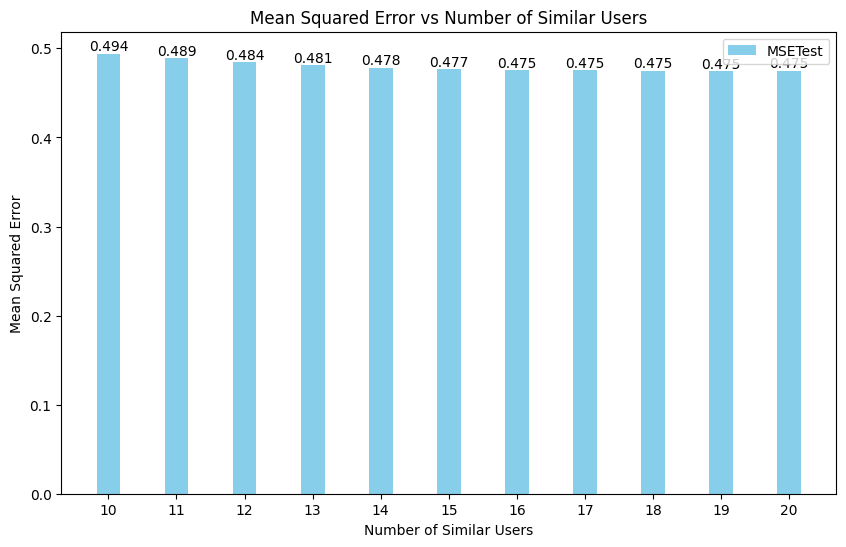

In [52]:
cf.plot_results(df_results)

In [53]:
print(f'Best params: {cf.best_params}, Best MSE: {cf.best_mse_test}')
res = cf.make_recommendations_user(user_id=55, num_recommendations=20)
res.show()

Best params: {'rank': 10, 'regParam': 0.1, 'maxIter': 10, 'numUsers': 19}, Best MSE: 0.47464702807694176
+----+----+---------+
|user|item|   rating|
+----+----+---------+
|  55| 352|4.4253345|
|  55| 335|3.9472497|
|  55| 422|3.6893568|
|  55| 199|3.4357786|
|  55| 456|3.4119596|
|  55| 196| 3.370279|
|  55|  95|3.3507597|
|  55| 257|3.3421004|
|  55|   8|3.3195114|
|  55| 439|3.3124905|
|  55| 437| 3.285025|
|  55| 239|3.2773952|
|  55| 438|3.2386374|
|  55| 262|3.2120264|
|  55| 251|3.1818209|
|  55| 356|3.1670544|
|  55| 464|3.1670544|
|  55| 454|3.1670544|
|  55|  12| 3.109748|
|  55|  15|3.0618691|
+----+----+---------+



In [54]:
print(f'Best params: {cf.best_params}, Best MSE: {cf.best_mse_test}')
res = cf.make_recommendations_item(item_id=352, num_recommendations=20)
res.show()

Best params: {'rank': 10, 'regParam': 0.1, 'maxIter': 10, 'numUsers': 19}, Best MSE: 0.47464702807694176
+----+----+---------+
|item|user|   rating|
+----+----+---------+
| 352|   1|4.8855176|
| 352|  32| 4.453047|
| 352|  55|4.4253345|
| 352|  41|4.3970222|
| 352|  50|4.2273903|
| 352|  72| 4.015167|
| 352|  71|3.9610286|
| 352|  69|3.9535818|
| 352|  56| 3.929315|
| 352|  64|3.9155207|
| 352|  46|3.3819664|
| 352|  21|3.3557096|
| 352|  14| 3.189015|
| 352|  35|3.1153104|
| 352|  49|3.0909026|
| 352|  42|2.9488816|
| 352|  22|2.8665767|
| 352|   9|2.8573644|
| 352|  33|2.8508577|
| 352|  48|  2.84253|
+----+----+---------+



# Câu 4: Dự đoán giá chứng khoán

In [55]:
class StockData:
    def __init__(self, file_path, k=3):
        self.file_path = file_path
        self.spark = SparkSession.builder.appName("StockPrediction").getOrCreate()
        self.k = k
        self.data = None
        self.new_data = None
        self.df_with_vectors = None
        self.window_spec = Window.orderBy(F.col("year").desc(), F.col("month").desc(), F.col("day").desc())

    def load_and_prepare_data(self):
        data = self.spark.read.csv(self.file_path, header=True, inferSchema=True)
        split_date = F.split(data["Ngay"], "/")
        data = data.withColumn("day", split_date.getItem(0).cast("int")) \
                   .withColumn("month", split_date.getItem(1).cast("int")) \
                   .withColumn("year", split_date.getItem(2).cast("int")) \
                   .select("day", "month", "year", "HVN")
        return data

    def calculate_fluctuation(self, data):
        lead_price = F.lead(F.col("HVN"), 1).over(self.window_spec)
        fluctuation = F.coalesce((F.col("HVN") - lead_price) / lead_price, F.lit(0.0))
        data = data.withColumn("fluctuation", fluctuation)
        return data

    def calculate_amplitudes(self, data):
        window_spec = Window.orderBy(F.col("year").desc(), F.col("month").desc(), F.col("day").desc())
        win_spec_k = window_spec.rowsBetween(1, self.k)
        new_data = data.withColumn("k_day_amplitude", F.reverse(F.collect_list("fluctuation").over(win_spec_k)))
        new_data = new_data.withColumn("k_day_amplitude",
                                      F.when(F.size(new_data["k_day_amplitude"]) < self.k,
                                              F.concat(F.array_repeat(F.lit(0), self.k - F.size(new_data["k_day_amplitude"])),new_data["k_day_amplitude"]))
                                              .otherwise(new_data["k_day_amplitude"]))

        return new_data



    def transform_to_vector(self, new_data):
        def list_to_vector_udf_nested(l):
            return Vectors.dense(l)

        list_to_vector_udf_nested = F.udf(list_to_vector_udf_nested, VectorUDT())
        df_with_vectors = new_data.withColumn('last_k_fluctuation', list_to_vector_udf_nested(new_data['k_day_amplitude'])) \
                                  .select("last_k_fluctuation", "fluctuation", "month")
        return df_with_vectors

    def split_data(self, data):
        train_data = data.filter(F.col("month") <= 6).select("last_k_fluctuation", "fluctuation")
        test_data = data.filter(F.col("month") > 6).select("last_k_fluctuation", "fluctuation")
        return train_data, test_data

    def create_data(self):
        self.data = self.load_and_prepare_data()
        self.data = self.calculate_fluctuation(self.data)
        self.new_data = self.calculate_amplitudes(self.data)
        self.df_with_vectors = self.transform_to_vector(self.new_data)

    def get_data(self):
        if self.df_with_vectors is None:
            self.create_data()
        return self.df_with_vectors


# Usage
file_path = path+'stockHVN2022.csv'
stock_data = StockData(file_path)
stock_data.create_data()
data = stock_data.get_data()
train_data, test_data = stock_data.split_data(data)
print("Train data:")
train_data.show(5,truncate=False)
print("Test data:")
test_data.show(5,truncate=False)

Train data:
+-----------------------------------------------------------------+---------------------+
|last_k_fluctuation                                               |fluctuation          |
+-----------------------------------------------------------------+---------------------+
|[0.06885245901639349,0.012269938650306704,-0.02727272727272723]  |-0.034267912772585715|
|[-0.003267973856209197,0.06885245901639349,0.012269938650306704] |-0.02727272727272723 |
|[-0.003257328990227944,-0.003267973856209197,0.06885245901639349]|0.012269938650306704 |
|[0.02675585284280939,-0.003257328990227944,-0.003267973856209197]|0.06885245901639349  |
|[0.023972602739726005,0.02675585284280939,-0.003257328990227944] |-0.003267973856209197|
+-----------------------------------------------------------------+---------------------+
only showing top 5 rows

Test data:
+----------------------------------------------------------------+--------------------+
|last_k_fluctuation                                   

Train MSE: 0.0005788157807408016
Test MSE: 0.0006217807601481779


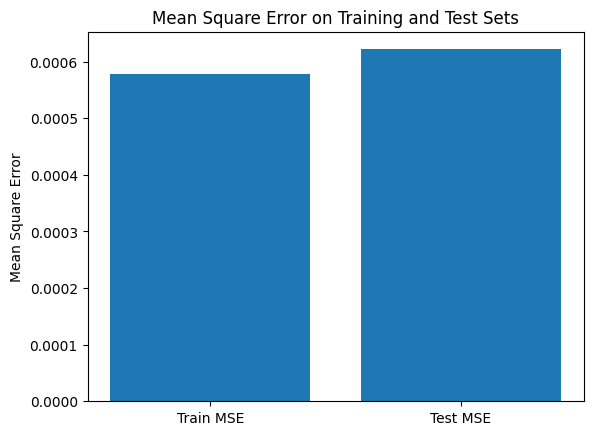

In [56]:
class StockModel:
    def __init__(self, train_data, test_data):
        self.train_data = train_data
        self.test_data = test_data
        self.lr_model = None

    def train(self):
        lr = LinearRegression(featuresCol="last_k_fluctuation", labelCol="fluctuation")
        self.lr_model = lr.fit(self.train_data)

    def evaluate(self):
        train_predictions = self.lr_model.transform(self.train_data)
        test_predictions = self.lr_model.transform(self.test_data)

        evaluator = RegressionEvaluator(labelCol="fluctuation", predictionCol="prediction", metricName="mse")
        train_mse = evaluator.evaluate(train_predictions)
        test_mse = evaluator.evaluate(test_predictions)

        return train_mse, test_mse

    def plot_mse(self, train_mse, test_mse):
        plt.bar(['Train MSE', 'Test MSE'], [train_mse, test_mse])
        plt.ylabel('Mean Square Error')
        plt.title('Mean Square Error on Training and Test Sets')
        plt.show()


stock_model = StockModel(train_data, test_data)
stock_model.train()
train_mse, test_mse = stock_model.evaluate()
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
stock_model.plot_mse(train_mse, test_mse)

# Câu 5: Phân loại đa lớp với pyspark

Train Accuracy (OneVsRest): 0.877333667460218
Test Accuracy (OneVsRest): 0.8628033680039624
Train Log Loss (MultilayerPerceptronClassifier): 0.0999539981884838
Test Log Loss (MultilayerPerceptronClassifier): 0.2599573596454811
Train Accuracy (MultilayerPerceptronClassifier): 0.9700538779601554
Test Accuracy (MultilayerPerceptronClassifier): 0.9262010896483408
Train Accuracy (RandomForestClassifier): 0.8758300964791379
Test Accuracy (RandomForestClassifier): 0.8553739474987617


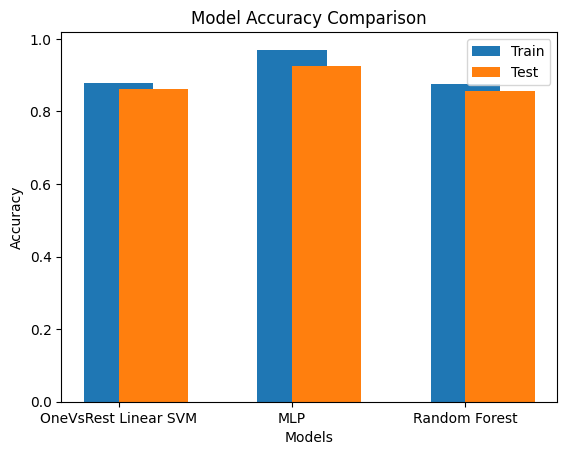

In [57]:
class MNISTClassifier:
    def __init__(self, spark):
        self.spark = spark

    def load_data(self, file_path):
        """
        Loads the MNIST dataset from a CSV file using SparkSession's read.csv() method.
        """
        self.data = self.spark.read.csv(file_path, header=False, inferSchema=True)

    def preprocess_data(self):
        """
        Preprocesses the dataset by renaming the first column to 'label' and creating a feature vector using VectorAssembler.
        """
        self.data = self.data.withColumnRenamed('_c0', 'label')
        assembler = VectorAssembler(inputCols=self.data.columns[1:], outputCol="features")
        self.data = assembler.transform(self.data).select('label', 'features')

    def split_data(self, train_ratio):
        """
        Splits the dataset into training and testing sets based on the provided ratio.
        """
        return self.data.randomSplit([train_ratio, 1 - train_ratio])

    def train_model(self, model, train_data):
        """
        Trains a machine learning model on the training data using Spark ML fit() method.
        """
        return model.fit(train_data)

    def evaluate_accuracy(self, model, data):
        """
        Evaluates the accuracy of a model on the given data using MulticlassClassificationEvaluator with accuracy metric.
        """
        predictions = model.transform(data)
        evaluator = MulticlassClassificationEvaluator(metricName="accuracy", labelCol='label')
        accuracy = evaluator.evaluate(predictions)
        return accuracy

    def evaluate_log_loss(self, model, data):
        """
        Evaluates the log loss of a model on the given data using MulticlassClassificationEvaluator with logLoss metric.
        """
        predictions = model.transform(data)
        evaluator = MulticlassClassificationEvaluator(metricName="logLoss", labelCol='label')
        log_loss = evaluator.evaluate(predictions)
        return log_loss

    def plot_accuracy(self, accuracies_train, accuracies_test):
        """
        Plots the accuracy of different models on the training and testing data using matplotlib.
        """
        models = ['OneVsRest Linear SVM', 'MLP', 'Random Forest']
        x = range(len(models))

        plt.bar(x, accuracies_train, width=0.4, label='Train', align='center')
        plt.bar(x, accuracies_test, width=0.4, label='Test', align='edge')

        plt.xlabel('Models')
        plt.ylabel('Accuracy')
        plt.title('Model Accuracy Comparison')
        plt.xticks(x, models)
        plt.legend()
        plt.show()

    def run(self, file_path, train_ratio=0.8):
        """
        Runs the entire MNISTClassifier pipeline, including data loading, preprocessing, training, evaluation, and plotting.
        """
        self.load_data(file_path)
        self.preprocess_data()
        train_data, test_data = self.split_data(train_ratio)

        mlp = MultilayerPerceptronClassifier(layers=[784, 256, 128, 10], seed=123, featuresCol='features', labelCol='label')
        rf = RandomForestClassifier(numTrees=100, seed=123, featuresCol='features', labelCol='label')
        lsvc = LinearSVC(maxIter=10, regParam=0.1, featuresCol='features', labelCol='label')
        lsvc_ovr = OneVsRest(classifier=lsvc, featuresCol='features', labelCol='label')
        models = [lsvc_ovr, mlp, rf]

        accuracies_train = []
        log_losses_train = []
        accuracies_test = []
        log_losses_test = []

        for model in models:
            trained_model = self.train_model(model, train_data)

            train_accuracy = self.evaluate_accuracy(trained_model, train_data)
            test_accuracy = self.evaluate_accuracy(trained_model, test_data)
            accuracies_train.append(train_accuracy)
            accuracies_test.append(test_accuracy)

            if model != lsvc_ovr and model != rf:
                train_log_loss = self.evaluate_log_loss(trained_model, train_data)
                test_log_loss = self.evaluate_log_loss(trained_model, test_data)
                log_losses_train.append(train_log_loss)
                log_losses_test.append(test_log_loss)
                print(f"Train Log Loss ({model.__class__.__name__}): {train_log_loss}")
                print(f"Test Log Loss ({model.__class__.__name__}): {test_log_loss}")

            print(f"Train Accuracy ({model.__class__.__name__}): {train_accuracy}")
            print(f"Test Accuracy ({model.__class__.__name__}): {test_accuracy}")

        self.plot_accuracy(accuracies_train, accuracies_test)

if __name__ == "__main__":
    data_path_mnist_mini = "/content/drive/MyDrive/Big_Data/datasets/mnist_mini.csv"
    classifier = MNISTClassifier(spark)
    classifier.run(data_path_mnist_mini)
